In [1]:
%cd /glade/work/haiyingx/benchmarking/

/glade/work/haiyingx/benchmarking


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import hvplot.pandas
from distributed.utils import format_bytes, parse_bytes


In [3]:
li=[]
df0 = dd.read_csv('results/chey*/2020-06-16/compute_study_2020*.csv',dtype={'root': str}).compute()
li.append(df0)
df0['chunk_size'] = df0['chunk_size'].map(lambda x: format_bytes(parse_bytes(x)))
df0['dataset_size'] = df0['dataset_size'].map(lambda x: format_bytes(parse_bytes(x)))
df1 = dd.read_csv('results/chey*/2020-06-17/compute_study_2020*.csv',dtype={'root': str}).compute()
li.append(df1)
df1['chunk_size'] = df1['chunk_size'].map(lambda x: format_bytes(parse_bytes(x)))
df1['dataset_size'] = df1['dataset_size'].map(lambda x: format_bytes(parse_bytes(x)))
dfc=pd.concat(li)
dfc

,operation,chunk_size,chunk_per_worker,dataset_size,worker_per_node,threads_per_worker,num_nodes,chunking_scheme,io_format,filesystem,root,machine,maxmemory_per_node,maxcore_per_node,spil,runtime
0,writefile,64.00 MB,10,640.95 MB,1,1,1,temporal,zarr,posix,NaN,cheyenne,109gb,36,False,6.643409
1,openfile,64.00 MB,10,640.95 MB,1,1,1,temporal,zarr,posix,NaN,cheyenne,109gb,36,False,0.043192
2,readfile,64.00 MB,10,640.95 MB,1,1,1,temporal,zarr,posix,NaN,cheyenne,109gb,36,False,1.570875
3,deletefile,64.00 MB,10,640.95 MB,1,1,1,temporal,zarr,posix,NaN,cheyenne,109gb,36,False,0.078049
4,writefile,64.00 MB,10,640.95 MB,1,1,1,auto,zarr,posix,NaN,cheyenne,109gb,36,False,1.403832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,deletefile,256.00 MB,10,20.48 GB,1,1,8,temporal,zarr,posix,NaN,cheyenne,109gb,36,False,0.229200
36,writefile,256.00 MB,10,20.48 GB,1,1,8,temporal,zarr,s3,pangeo-bench-local/test1,cheyenne,109gb,36,False,75.784914
37,openfile,256.00 MB,10,20.48 GB,1,1,8,temporal,zarr,s3,pangeo-bench-local/test1,cheyenne,109gb,36,False,0.080514
38,readfile,256.00 MB,10,20.48 GB,1,1,8,temporal,zarr,s3,pangeo-bench-local/test1,cheyenne,109gb,36,False,23.339735


In [27]:
chunk_size_list = ['64.00MB','128.00 MB',  '256.00 MB', '512.00MB' ]
d1 = dfc[dfc['chunk_size'] == '64.00 MB']
d2 = dfc[dfc['chunk_size'] == '128.00 MB']
d3 = dfc[dfc['chunk_size'] == '256.00 MB']
d4 = dfc[dfc['chunk_size'] == '512.00 MB']
dd={}
dd['netcdf_posix'] = dfc[(dfc['io_format'] == 'netcdf') & (dfc['filesystem'] == 'posix')]
dd['netcdf_s3'] = dfc[(dfc['io_format'] == 'netcdf') & (dfc['filesystem'] == 's3')]
dd['zarr_posix'] = dfc[(dfc['io_format'] == 'zarr') & (dfc['filesystem'] == 'posix')]
dd['zarr_s3'] = dfc[(dfc['io_format'] == 'zarr') & (dfc['filesystem'] == 's3')]

#df = pd.DataFrame() 
df = pd.concat([d1, d2,d3,d4])
df = df.drop(df.index[df.num_nodes > 16])



In [15]:
#df = get_renamed_df(dd)
#df3 = get_normalized_df(df1)
x='num_nodes'
y='runtime'
by=['chunk_size']
groupby=[ 'operation','chunking_scheme','io_format','filesystem']
dfplot = df.sort_values(x).reset_index()
    #clean_df = clean_df



dfplot = dfplot.drop(dfplot.index[dfplot.num_nodes > 16])

In [45]:
dfplot.hvplot.scatter(x=x,y=y,by=by,groupby=groupby, ylim=(0,10), xlim=(0,17), xticks=(1, 2, 4, 8, 16))

:DynamicMap   [operation,chunking_scheme,io_format,filesystem]
   :NdOverlay   [chunk_size]
      :Scatter   [num_nodes]   (runtime)

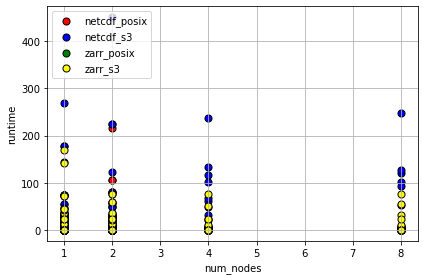

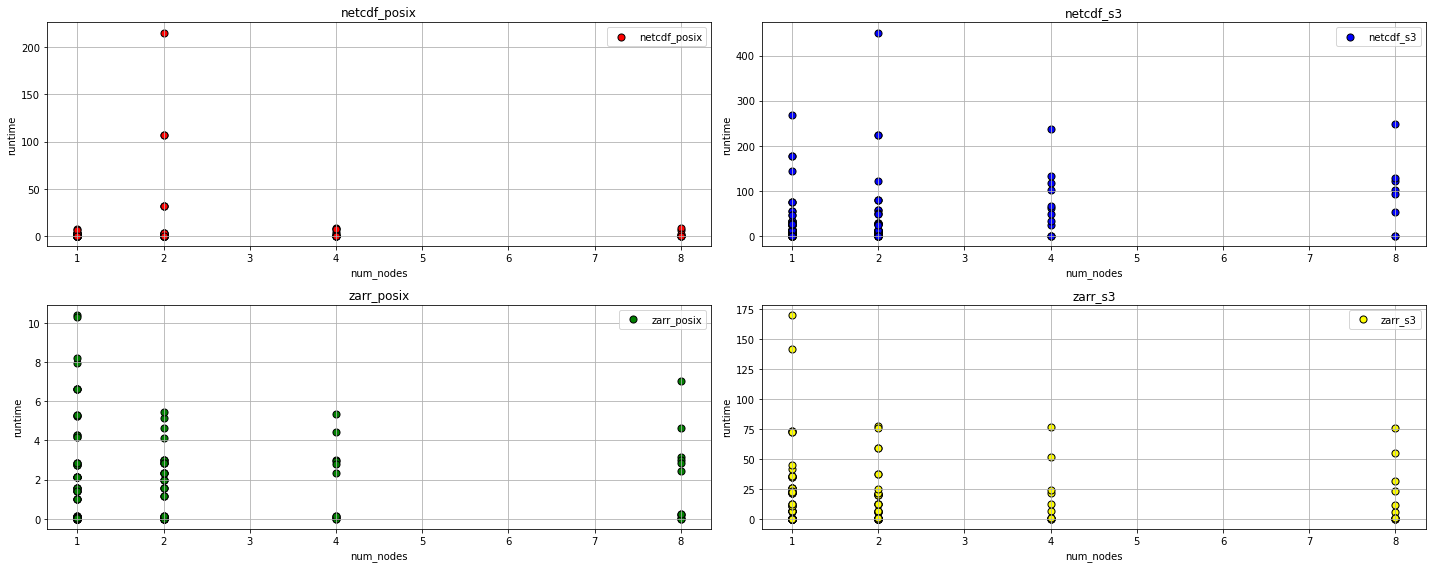

In [36]:
fig0, ax0 = plt.subplots()
fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))
colormap = ['red', 'blue', 'green', 'yellow', 'BuPu', 'BuPu_r','plasma', 'alpha']
#palette = sns.color_palette('colorblind', len(files))

for (name, df), color, ax1 in zip(dd.items(), colormap, axs.flat):
    for ax in [ax0, ax1]:
        df.plot(kind='scatter', x='num_nodes', y='runtime',
                  s=50, c=[color], edgecolor='k', ax=ax, label=name)
    ax1.grid()
    ax1.set_title(name)

ax0.grid()
ax0.legend(loc='upper left')

fig0.tight_layout()
fig1.tight_layout()

In [37]:
dfplot.hvplot.box(y, by=x,groupby=['operation', 'chunking_scheme','chunk_size','io_format', 'filesystem'])

:DynamicMap   [operation,chunking_scheme,chunk_size,io_format,filesystem]
   :BoxWhisker   [num_nodes]   (runtime)

In [38]:
def get_clean_df(df):
    groupby=[ 'chunking_scheme', 'chunk_size','operation', 'num_nodes','io_format']
    clean_df = df.groupby(groupby).runtime.agg([ 'mean', 'median', 'std','count']).reset_index()
    clean_df['mean+std']=clean_df['mean'] + clean_df['std']
    clean_df['mean-std']=clean_df['mean'] - clean_df['std']
    clean_df.sort_values(by=[ 'num_nodes']).reset_index()
    clean_df = clean_df.drop(columns=[ 'mean', 'std'])

    return clean_df

analyseddf = get_clean_df(df)

print('each tests were done ', analyseddf['count'].min() ,' to ', analyseddf['count'].max() ,'times')
print('in total we have done',  len(df)  , 'computations')
print('run time of each computasion varied from', df.runtime.min(),' to', df.runtime.max() ,'seconds' )
analyseddf.head(10)

each tests were done  1  to  4 times
in total we have done 152 computations
run time of each computasion varied from 0.02021694183349609  to 170.19576621055603 seconds


,chunking_scheme,chunk_size,operation,num_nodes,io_format,median,count,mean+std,mean-std
0,auto,128.00 MB,deletefile,1,zarr,0.196827,3,0.196827,0.196827
1,auto,128.00 MB,deletefile,2,zarr,0.310274,2,0.310274,0.310274
2,auto,128.00 MB,openfile,1,zarr,0.054807,3,0.054807,0.054807
3,auto,128.00 MB,openfile,2,zarr,0.060214,2,0.060214,0.060214
4,auto,128.00 MB,readfile,1,zarr,12.315062,3,12.315062,12.315062
5,auto,128.00 MB,readfile,2,zarr,12.267872,2,12.267872,12.267872
6,auto,128.00 MB,writefile,1,zarr,35.848110,3,35.848110,35.848110
7,auto,128.00 MB,writefile,2,zarr,37.489123,2,37.489123,37.489123
8,auto,256.00 MB,deletefile,1,zarr,0.350073,2,0.350073,0.350073
9,auto,256.00 MB,deletefile,2,zarr,0.456867,1,NaN,NaN


In [39]:
def get_normalized_df(df,key='median'):
    #normalize runtime
    dfnew = pd.DataFrame() 
    chunking_scheme_list = set(df['chunking_scheme'])
    operation_list = set(df['operation'])
    chunk_size_list = set(df['chunk_size'])
    for operation in operation_list: 
        df1 = df.query('operation == "{operation}"'.format(operation = operation)).copy() 
        for chunk_size in chunk_size_list: 
            df2 = df1.query('chunk_size == "{chunk_size}"'.format(chunk_size = chunk_size)).copy() 
            for chunking_scheme in chunking_scheme_list: 
                seg = df2.query('chunking_scheme == "{chunking_scheme}"'.format(chunking_scheme = chunking_scheme)).copy() 
                seg['normalized'] = seg[key]
                #seg.normalized= seg.normalized/seg[seg.num_nodes == 1 ].normalized.min()
                tt= seg[seg.num_nodes == 1 ]
                norm=tt['median'].min()
                seg.normalized= seg.normalized/norm
                dfnew = pd.concat([dfnew,seg])
    return dfnew


In [40]:
df1 = get_normalized_df(analyseddf,key='median')
df1['normalized_median'] = df1.normalized
df1=df1.drop(columns=['normalized'])

In [41]:
df2 = get_normalized_df(df1,key='mean+std')
df2['normalized_mean+std'] = df2.normalized
df2=df2.drop(columns=['normalized'])
df3 = get_normalized_df(df2,key='mean-std')
df3['normalized_mean-std'] = df3.normalized
df3=df3.drop(columns=['normalized'])

In [42]:
def log_linear_plot(df, loglog=False, plot_kind='line', x='num_nodes', y='normalized_median', ylabel='Normalized runtime ', 
                    y1='normalized_mean-std',
                    y2='normalized_mean+std',
                    by=['chunk_size'], subplots=True, groupby=['operation', 'chunking_scheme'], 
                    ylim=(0.9, 2),xticks=(1, 2, 4, 8, 16), shared_axes=True,
                    figname='test',png=False,col=1):
    if loglog:
        title = f'{y} vs {x} -- Log scale'
    else:
        title = f'{y} vs {x} -- Linear scale'
    legend = 'right'
    
    ylabel='Normalized run time'
    xlabel='Number of nodes'
    

    def hook(plot, element):
        plot.handles['xaxis'].axis_label_text_font_style = 'bold'
        plot.handles['yaxis'].axis_label_text_font_style = 'bold'
        plot.handles['xaxis'].axis_label_text_font = 'times new roman' 
        plot.handles['yaxis'].axis_label_text_font = 'times new roman' 
        plot.handles['plot'].legend.label_text_font = "times new roman"
        plot.handles['plot'].title.text_font = "times new roman"
        plot.handles['plot'].plot_width = 500
        plot.handles['plot'].plot_height = 225



        
    if subplots:
        line = df.hvplot(x=x, y=y, by=by,
        groupby=groupby,
        height=400,width=500,
        loglog=loglog, 
        kind=plot_kind, title=title, xlabel=xlabel,ylabel=ylabel,
        dynamic=False, 
                         legend=legend, 
                         use_index=False,shared_axes=shared_axes,
        yaxis='left',
        #xticks=xticks,
        fontsize={'xticks':12,'yticks':12,'ylabel':12, 'xlabel':12,'title':14,'legend':12 },

        xticks=[(1,1),(2, 2),(3, ' '),(4, 4), (5, ' '), (6, ' '), (7, ' '),(8,8),(9, ' '), (10, ' '), (11, ' '), (12, ' '), (13, ' '), (14, ' '), (15, ' '),(16,16)],
        yticks=(1.0,1.2,1.4,1.6,1.8,2.0),
        ylim=ylim).layout().cols(col)
        area = df.hvplot.area(x=x,y=y1,y2=y2, by=by, alpha=0.2, 
                              groupby=groupby, loglog=loglog, 
                                      height=300,width=500,
                              stacked=False).opts(hooks=[hook]).layout().cols(1)


    else:
        line = df.hvplot(x=x, y=y, by=by,
                  groupby=groupby,height=300,width=500,
                  rot=45, loglog=loglog, 
                  kind=plot_kind, title=title, ylabel=ylabel,
                  dynamic=False, legend=legend,use_index=False,shared_axes=shared_axes,
                  ylim=ylim)
    fig= line *area
    #* area
    #if png: 
    #    hvplot.save(fig, figname)
    return fig

In [43]:
log_linear_plot(df3[df3.chunking_scheme == 'temporal'] , col=1,y='normalized_median',groupby=['operation'],figname='cheyenneweakauto.png',
                png=True)

:NdLayout   [operation]
   :Overlay
      .NdOverlay.I  :NdOverlay   [chunk_size]
         :Curve   [num_nodes]   (normalized_median)
      .NdOverlay.II :NdOverlay   [chunk_size]
         :Area   [num_nodes]   (normalized_mean-std,normalized_mean+std)